# Cancer Classification with Gene Expression Data



Steps: \
1) Load expression data into Pandas dataframe \
2) Perform dimensionality reduction with PCA \
3) Classification using ML models (e.g. SVM) \

Link to data: http://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz 

Use ```tar -xvf TCGA-PANCAN-HiSeq-801x20531.tar.gz``` command to extract files.

Cancer type abbreviations:\
BRCA = breast invasive carcinoma\
KIRC = kidney renal clear cell carcinoma\
COAD = colon adenocarcinoma\
LUAD = lung adenocarcinoma\
PRAD = prostate adenocarcinoma 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
!ls gdrive/MyDrive/ECE196/TCGA-PANCAN-HiSeq-801x20531/
path_to_data = "gdrive/MyDrive/ECE196/TCGA-PANCAN-HiSeq-801x20531/"#change depending on where the data's stored in Google Drive

data.csv  labels.csv


## Data Cleaning

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

In [6]:
#Load gene expression data into a pandas dataframe
data_df = pd.read_csv(path_to_data+"data.csv",index_col=0,usecols=list(range(0,1001)))#gene expression values; Note: only loads the first 1,000 genes of the dataset
labels_df = pd.read_csv(path_to_data+"labels.csv",index_col=0)#cancer labels

gene_express_df = pd.concat([labels_df,data_df],axis=1)#combine labels w/ expression values
gene_express_df.reset_index(drop=True, inplace=True)#Reset index labels, ie change'sample_0' to '0' 
gene_express_df = gene_express_df.dropna()

labels_df.reset_index(drop=True, inplace=True)
data_df.reset_index(drop=True,inplace=True)

labels_df #just labels
data_df #just data
#gene_express_df #labels + data

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29,gene_30,gene_31,gene_32,gene_33,gene_34,gene_35,gene_36,gene_37,gene_38,gene_39,...,gene_960,gene_961,gene_962,gene_963,gene_964,gene_965,gene_966,gene_967,gene_968,gene_969,gene_970,gene_971,gene_972,gene_973,gene_974,gene_975,gene_976,gene_977,gene_978,gene_979,gene_980,gene_981,gene_982,gene_983,gene_984,gene_985,gene_986,gene_987,gene_988,gene_989,gene_990,gene_991,gene_992,gene_993,gene_994,gene_995,gene_996,gene_997,gene_998,gene_999
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,0.591871,1.334282,2.015391,0.591871,0.000000,0.0,0.000000,0.000000,0.591871,5.619994,1.334282,0.000000,9.796088,0.0,0.000000,1.598651,7.215116,10.839070,6.620204,9.513538,0.000000,4.063658,7.764805,4.747656,13.714396,10.034496,0.000000,0.000000,9.833458,0.000000,...,10.281988,9.148459,9.794442,9.866753,10.062141,8.321933,10.317978,8.973201,3.266292,8.434069,10.180991,6.504090,9.612931,8.586502,9.103943,7.165018,10.020480,8.928853,10.588921,9.604498,8.397649,5.801490,6.296364,1.010279,7.653397,9.488079,9.279035,10.599801,9.845438,10.642277,2.476226,3.542295,0.000000,6.446529,2.185898,7.319582,9.814895,5.785132,2.068705,11.881389
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,0.000000,0.587845,2.466601,1.004394,0.000000,0.0,0.000000,0.000000,0.000000,11.055208,3.562621,0.000000,10.070470,0.0,0.000000,0.000000,9.949812,8.522476,1.174790,4.926991,0.000000,0.000000,5.819832,1.327170,13.286240,6.663316,0.587845,0.000000,9.533302,0.811142,...,11.745065,6.339581,9.390302,9.324475,10.067770,8.768641,10.810274,10.704431,0.811142,10.877207,3.622766,5.516375,9.807236,6.948285,10.772191,8.935050,9.428720,8.073483,11.178379,10.316530,9.401613,6.405274,6.882142,1.174790,9.194252,9.744878,8.823335,10.538684,10.189923,10.160098,2.865543,6.374989,0.587845,7.964387,4.915373,6.652541,9.010164,7.016574,2.038717,10.405641
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,0.000000,0.452595,1.981122,1.074163,0.000000,0.0,0.000000,0.000000,1.683023,8.210248,4.195285,3.660427,8.970920,0.0,0.000000,0.796598,6.096650,9.861616,7.680507,3.119439,0.000000,0.452595,7.899526,0.000000,10.731098,6.967883,0.452595,0.000000,9.646323,0.452595,...,11.030805,5.932262,8.610530,8.834338,9.683649,7.296834,9.843213,9.148159,3.677147,8.004136,9.820463,4.839808,8.273465,7.191661,7.266084,6.378062,10.347090,6.702907,11.425583,10.789346,9.912150,8.392150,7.213328,3.352236,8.821471,11.002843,8.988818,9.897732,10.406269,10.881741,3.403377,3.677147,0.000000,7.169685,0.452595,6.738200,8.893666,5.808720,2.181898,11.609170
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,0.000000,0.434882,2.874246,0.000000,0.000000,0.0,0.000000,0.000000,1.267356,8.306317,3.573556,0.000000,8.524616,0.0,0.000000,0.000000,3.913761,9.511573,6.469165,7.029895,0.000000,1.267356,6.800641,7.742714,12.659474,8.299890,0.768587,0.000000,9.670731,0.434882,...,12.054770,6.212809,9.003394,9.102742,9.751260,7.475328,10.114302,7.740341,3.184471,9.876945,10.734422,7.990325,9.669484,7.042929,9.438846,6.286179,10.552756,8.839125,11.489231,10.691185,9.629677,6.735211,7.293177,0.768587,8.565376,10.366508,8.018000,10.812129,10.814671,10.507795,2.803310,2.283833,0.000000,7.644671,1.039419,8.717803,8.839125,6.545260,1.480575,11.922172
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,0.000000,1.275841,2.141204,0.000000,0.000000,0.0,0.000000,0.000000,0.889707,10.149150,2.967630,0.000000,8.047238,0.0,1.435949,0.000000,1.942120,8.821535,5.861429,7.755709,0.000000,0.649386,5.570241,2.612801,13.556734,8.004754,0.000000,0.000000,9.587569,0.649386,...,12.520773,7.263542,8.876670,10.902066,10.039248,9.589700,10.055526,11.681142,3.525831,8.745221,9.625446,6.812947,10.351050,6.545175,9.216372,8.906888,10.

## Dimensionality Reduction

### Background on PCA

PCA is a method of reducing dimensions in a large dataset while trying to preserve the information in that dataset. 

The first step of PCA requires standardization of the values so that each feature has the same 'weight'. This is done by setting the mean of each column within the dataset to 0 and the variance to 1. 

From the features in the dataset PCA produces principal components which best explain variance across samples in the data. The first principal component explains the highest amount of variance in the data, the second principal component explains the second most variance, and so on. Principal components are also designed so that each principal component is uncorrelated to the others. 

This allows us to retain information and filter out the effects of features that don't contribute information to our classification. 

Unlike the original features in the dataset(genes), principal components don't actually have any human meaning. 

References: 
- https://builtin.com/data-science/step-step-explanation-principal-component-analysis 
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

### Visualization with PCA

In [7]:
#Standardize data
features = list(gene_express_df.columns.values)[1:]#list of features/genes

y = gene_express_df[['Class']]#dataframe of cancer labels
x = gene_express_df[features]#dataframe of expression values for each gene

scaler = StandardScaler()
x = scaler.fit_transform(x)#standardizes data so that the mean value is 0 and the variance is 1, Note:the output is a numpy.ndarray

In [8]:
#Perform PCA using 2 components
pca = PCA(n_components=2)
pc2 = pca.fit_transform(x) #get the principal components
pc2_df = pd.DataFrame(data = pc2, columns = ['PC1', 'PC2'])#change principal components numpy.ndarray into a dataframe
pc2_labeled_df = pd.concat([y,pc2_df], axis = 1)#concatenate labels with principal component values

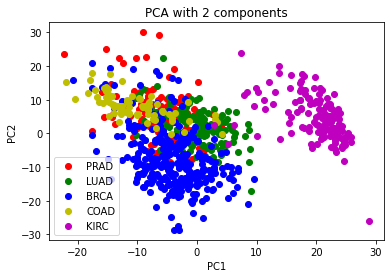

In [9]:
#Graph 2-dimensional PCA
x_vals = pc2_labeled_df['PC1'] 
y_vals = pc2_labeled_df['PC2'] 

fig, ax = plt.subplots()

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA with 2 components')

labels = ['PRAD','LUAD','BRCA','COAD','KIRC']
colors = ['r','g','b','y','m']
for label,color in zip(labels,colors):
  indices = pc2_labeled_df['Class'] == label
  ax.scatter(pc2_labeled_df.loc[indices, 'PC1'],pc2_labeled_df.loc[indices, 'PC2'],c = color)

ax.legend(labels)
plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.11717688593571846, 0.20778007320171382, 0.28961835342561437, 0.34286295595054933, 0.38563915488071343, 0.4184349168865654, 0.4437088378588987, 0.4676098529058924, 0.48471829745251555, 0.49757164072604326, 0.508786389969601, 0.5186776674940919, 0.5280792952329028, 0.5362695578588467, 0.5435886329891959, 0.5508514614558286, 0.5572450084698614, 0.5635164030543891, 0.5696164668794588]


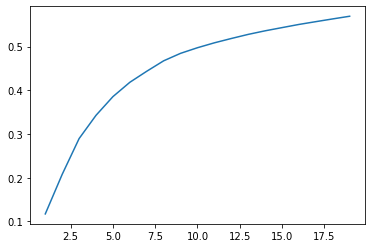

In [10]:
#TODO: Create a scree plot to visualize total variance retained for n components

scree_x = np.array(range(1,20))
scree_y = []


print(scree_x)
#pca = PCA(n_components=1)
#pctest = pca.fit_transform(x)
#print(sum(pca.explained_variance_ratio_))

for n in list(scree_x):
  pca = PCA(n_components=n)
  pctest = pca.fit_transform(x)
  scree_y.append(sum(pca.explained_variance_ratio_))
  #print(sum(pca.explained_variance_ratio_))

print(scree_y)

plt.plot(scree_x,scree_y)
plt.show()

## Modeling

### Model selection

For a classification problem, typically there are many choices to consider. For example, if the problem is simple (a linear classifier would work), then even a linear model can solve the problem. If the problem is rather complicated, which requires many dimensions and many categories, then we can consider more complex models like KNN, SVM, ANN, etc.

SVM is one of these classification methods. The idea of SVM is to build decision boundaries that have "margins" between different groups of data points. In this way, SVM increases the generalizability of the model and also increases its accuracy since it can tolerate data with noise by the margin it creates. 

SVM originally works only as a linear classifier, which means that it draws straight lines to separate different groups of data. However, in many cases we also need to draw curl lines to best separate different groups of data, meaning that we need a non-linear classifier. To do so, we can use a slightly modifed version of SVM, called SVM with kernel. The kernel is essentially the secret sauce to non-linearity, and by default sklearn uses a kernel called rbf kernel to achieve a good result.

In this project we want to try SVM first for the following reasons:

*   Fast training. Our dataset is rather small (around 800 samples). SVM trains in O(n^2) time with regard to sample amount n, so it can efficiently learn a good decision boundary under our current situation. Even with more data, like tens of thousands of cancer data, SVM still has a very good runtime. 
*   High accuracy. It can be shown in the Training section that with a high-dimension PCA decomposition, the SVM actually achieves near 1.0 test accuracy. 


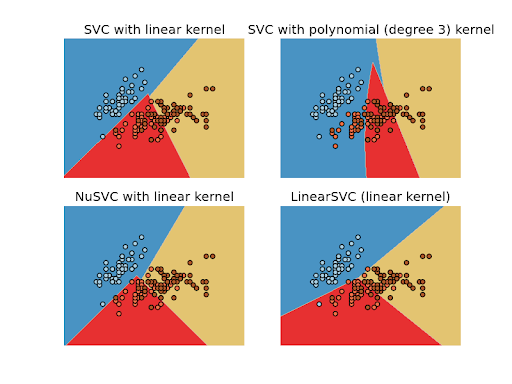






To compare the performance of different algorithms, we also plan to use KNN and Decision Tree algorithms. 

### Training

As above, we've shown that by doing the PCA analysis, we found the two most significant features so that we can reduce the dimensionality of each observation into 2 dimensions. Thus, we first try to classify the dimensionality-reduced data using machine learning methods.

However, it seems that 2 dimensions is not enough to classify all of those. We want to try to use more dimensions.

In [11]:
def svm_score(n_components):
  # apply PCA to the x variables
  # encode the label as integers
  pca = PCA(n_components=n_components)
  le = preprocessing.LabelEncoder()
  x_data = gene_express_df.to_numpy()[:, 1:]
  y_data = gene_express_df.to_numpy()[:, 0]
  x_all = pca.fit(x_data).fit_transform(x_data)
  y_all = le.fit(y_data).transform(y_data).reshape((y_data.shape[0], 1))

  # randomly split data and select 100 training samples
  training_set = np.concatenate((y_all, x_all), axis=1)
  np.random.shuffle(training_set)
  x_all = training_set[:, 1:]
  y_all = training_set[:, 0]
  x_train = x_all[100:]
  y_train = y_all[100:]
  x_test = x_all[:100]
  y_test = y_all[:100]

  # Using SVC classifier, print out the test accuracy
  rbf = SVC(kernel='rbf')
  rbf.fit(x_train, y_train)
  return rbf.score(x_test, y_test)

In [12]:
svm_score(7)

1.0

### Other Models


Here we also try to do the classification problem using other algorithms (thanks to suggestion by instructor Nitesh Sunku). As shown in the figure where we did PCA with number of components of 2, the kidney cancer part can be clearly separated from the rest of the data points. However, the rest is a bit clustered. In that case, SVM needs more dimensions, while KNN and DT might still work on 2 dimensions and still achieve a good accuracy.

#### K-Nearest Neighbors

In [13]:
def knn_score(n_components):
  # apply PCA to the x variables
  # encode the label as integers
  pca = PCA(n_components=2)
  le = preprocessing.LabelEncoder()
  x_data = gene_express_df.to_numpy()[:, 1:]
  y_data = gene_express_df.to_numpy()[:, 0]
  x_all = pca.fit(x_data).fit_transform(x_data)
  y_all = le.fit(y_data).transform(y_data).reshape((y_data.shape[0], 1))

  # randomly split data and select 100 training samples
  training_set = np.concatenate((y_all, x_all), axis=1)
  np.random.shuffle(training_set)
  x_all = training_set[:, 1:]
  y_all = training_set[:, 0]
  x_train = x_all[100:]
  y_train = y_all[100:]
  x_test = x_all[:100]
  y_test = y_all[:100]

  # KNN
  knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
  knn.fit(x_train, y_train)
  return knn.score(x_test, y_test)

In [14]:
knn_score(n_components=4)

0.92

#### Decision Trees

BRCA = breast invasive carcinoma
KIRC = kidney renal clear cell carcinoma
COAD = colon adenocarcinoma
LUAD = lung adenocarcinoma
PRAD = prostate adenocarcinoma

In [15]:
def dt_score(n_components):
  #Split data into 7/8 training data and 1/8 testing data
  train_data,test_data,train_label,test_label = train_test_split(data_df,labels_df,test_size=1.0/8.0,random_state=0,stratify=labels_df)

  #Test the percentage of each label in the data (b/c we used stratify_labels, the testing & training data should have the same proportions of labels)
  b_sum = 0
  k_sum = 0
  c_sum = 0
  l_sum = 0
  p_sum = 0
  for x in labels_df['Class']:
    if x == 'BRCA':
      b_sum = b_sum +1
    if x == 'KIRC':
      k_sum = k_sum + 1
    if x =='COAD':
      c_sum = c_sum + 1
    if x == 'LUAD':
      l_sum = l_sum + 1
    if x == 'PRAD':
      p_sum = p_sum + 1

  total_sum = b_sum+k_sum+c_sum+l_sum+p_sum
  # print('BRCA: ' + str(b_sum/total_sum))
  # print('KIRC: ' + str(k_sum/total_sum))
  # print('COAD: ' + str(c_sum/total_sum))
  # print('LUAD: ' + str(l_sum/total_sum))
  # print('PRAD: ' + str(p_sum/total_sum))
  print(total_sum)


  #Scale data
  scaler = StandardScaler()
  scaler.fit(train_data)#fit only to the training data

  train_data = scaler.transform(train_data)
  test_data = scaler.transform(test_data)

  #Perform PCA
  pca = PCA(n_components=n_components)
  pca.fit(train_data)#again, fit pca only to the training data

  train_data = pca.transform(train_data)
  test_data = pca.transform(test_data)

  #Create decision tree model
  dc_clf = tree.DecisionTreeClassifier()

  dc_clf.fit(train_data, train_label)

  #Test performance with testing data
  return dc_clf.score(test_data, test_label)

In [16]:
dt_score(n_components=7)

801


0.9207920792079208

### Model Comparison

First we want make a comparison of different algorithms under different parameter n_components. 

In [17]:
tests_num = 20
svm = []
knn = []
dt = []
for i in range(1, tests_num+1):
  svm.append(svm_score(i))
  knn.append(knn_score(i))
  dt.append(dt_score(i))

#svm = [svm_score(1), svm_score(2), svm_score(3) svm_score(4), svm_score(7)]
#knn = [knn_score(1), knn_score(2), knn_score(4), knn_score(7)]
#dt = [dt_score(1), dt_score(2), dt_score(4), dt_score(7)]

801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801


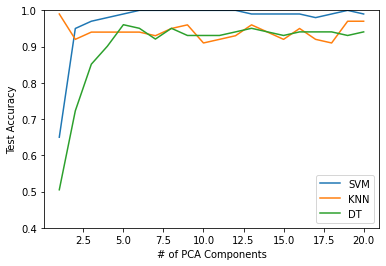

In [18]:
axes = plt.gca()
axes.set_ylim([0.4, 1])
plt.xlabel("# of PCA Components")
plt.ylabel("Test Accuracy")
plt.plot(list(range(1,tests_num+1)), svm, label='SVM')
plt.plot(list(range(1,tests_num+1)), knn, label='KNN')
plt.plot(list(range(1,tests_num+1)), dt, label='DT')
plt.legend()

In [19]:
print(svm)
print(knn)
print(dt)

[0.65, 0.95, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 1.0, 0.99]
[0.99, 0.92, 0.94, 0.94, 0.94, 0.94, 0.93, 0.95, 0.96, 0.91, 0.92, 0.93, 0.96, 0.94, 0.92, 0.95, 0.92, 0.91, 0.97, 0.97]
[0.504950495049505, 0.7227722772277227, 0.8514851485148515, 0.900990099009901, 0.9603960396039604, 0.9504950495049505, 0.9207920792079208, 0.9504950495049505, 0.9306930693069307, 0.9306930693069307, 0.9306930693069307, 0.9405940594059405, 0.9504950495049505, 0.9405940594059405, 0.9306930693069307, 0.9405940594059405, 0.9405940594059405, 0.9405940594059405, 0.9306930693069307, 0.9405940594059405]
